In [4]:
import pandas as pd

feature_name_df = pd.read_csv("./datasets/features.txt",sep='\s+',
           header=None,names=['column_index','column_name'])

feature_name = feature_name_df.iloc[:, 1].values.tolist()
print(feature_name[:10])

['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [5]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                              if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)

    return new_feature_name_df
    

In [6]:
import pandas as pd



def get_human_dataset():
    
    feature_name_df = pd.read_csv('./datasets/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    X_train = pd.read_csv('./datasets/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./datasets/test/X_test.txt', sep='\s+', names=feature_name)
    
    y_train = pd.read_csv('./datasets/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./datasets/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB


In [7]:
y_train['action'].value_counts()

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)

print(round(accuracy,4))
print('DecisionTreeClassifier 기본 하이퍼파라미터:', dt_clf.get_params())

0.8548
DecisionTreeClassifier 기본 하이퍼파라미터: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [9]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [6, 8, 10, 12, 16, 20, 24]
         }

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)
print('GridSearchCV 최고 평균 정확도 수치: ',round(grid_cv.best_score_, 4))
print('GridSearchCV 최적 하이퍼파라미터: ', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:  0.8513
GridSearchCV 최적 하이퍼파라미터:  {'max_depth': 16}


In [10]:
best_dt = grid_cv.best_estimator_

In [11]:
result = best_dt.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, result)

In [13]:
accuracy

0.8574821852731591

In [14]:
best_dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 156,
 'splitter': 'best'}

In [15]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf, out_file='human_tree.dot', class_names=["1","2","3","4","5","6"], feature_names=feature_name,\
                impurity=True,filled=True)

In [16]:
import graphviz

with open('human_tree.dot') as f:
    dot_graph=f.read()
graph = graphviz.Source(dot_graph)

In [17]:
graph.render(filename='humanity_tree_img', directory='./', format='png')

'humanity_tree_img.png'

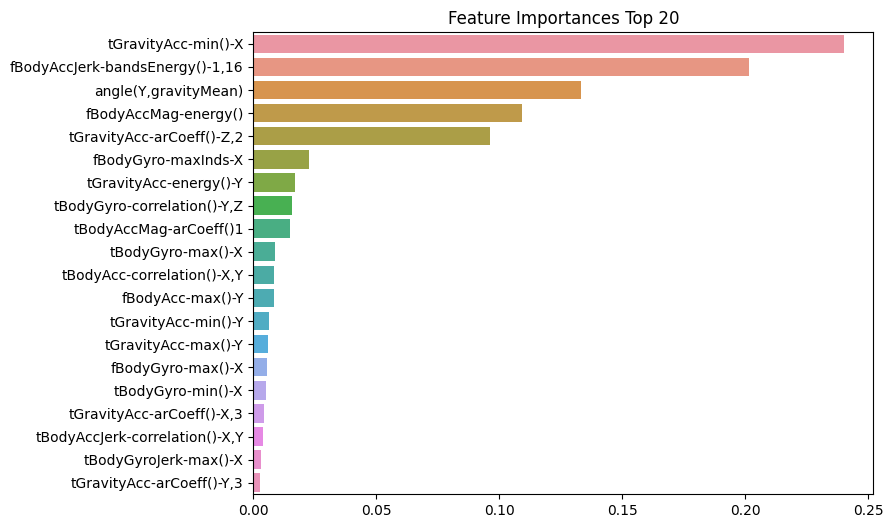

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = best_dt.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=[8, 6])
plt.title('Feature Importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()